In [22]:
from tempfile import TemporaryDirectory
from pathlib import Path
import subprocess
import shutil

import numpy as np
import tomlkit
import awkward as ak
import pandas as pd
import yaml
from IPython.display import display

In [8]:
base_config_yaml = """
candidates: 5
voters: 13
considerations:
- Likability:
    mean: 0.5
- Irrational:
    sigma: 1.0
    camps: 0
    individualism_deg: 30
- Issues:
    issues:
    - halfcsep: 0.0
      halfvsep: 0.0
      sigma: 1.0
methods:
- Plurality:
    strat: Honest
- Range:
    nranks: 10
    strat: Honest
- Range:
    nranks: 2
    strat: Honest
- Range:
    nranks: 2
    strat: Strategic
- InstantRunoff: {}
- Borda: {}
- Multivote:
    spread_fact: 1.0
    strat: Honest
    votes: 3
- STAR:
    strat: Honest
- STAR:
    strat: Strategic
    strategic_stretch_factor: 1.5
"""
config = yaml.safe_load(base_config_yaml)
VOTING = '../target/release/voting'

In [29]:
def do_run(config, trials) -> ak.Array:
    with TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        config_file = temp_dir / 'config.toml'
        with open(config_file, 'w') as fout:
            tomlkit.dump(config, fout)
        pq_file = temp_dir / 'results.parquet'
        cp = subprocess.run([
            VOTING,
            '-c', config_file,
            '-o', pq_file,
            '-t', str(trials),
        ], check=False, capture_output=True)
        last_config_file = '/tmp/voting_last_config.toml'
        shutil.copyfile(config_file, last_config_file);
        if cp.returncode != 0:
            print(cp.stderr)
            raise ValueError(f"voting process failed -- see perhaps {last_config_file}")
        results = ak.from_parquet(pq_file)
    return results

In [10]:
def get_fields(results):
    return list(filter(lambda fn: fn.startswith('m:'), results.fields))     

In [11]:
def run_experiment(config, parameter, pvalues, trials=2000):
    fields = None
    col_names = None
    regrets = []
    parameters = [int(p) if p.isnumeric() else p for p in parameter.split('.')]
    last_parameter = parameters.pop()
    for val in pvalues:
        conf_item = config
        for p in parameters:  # drill down into config
            conf_item = conf_item[p]
        assert last_parameter in conf_item, f"No such parameter {last_parameter}"
        conf_item[last_parameter] = val
        results = do_run(config, trials)
        fields = get_fields(results)
        if col_names is None:
            col_names = [f[2:] for f in fields]
        regrets.append([val] + [ak.mean(results[f]['regret']) for f in fields])
    return pd.DataFrame(regrets, columns=[parameter] + col_names)

In [31]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(config, 'voters', [7, 9, 11, 13, 15, 51], trials=10000)
df

,voters,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_3v,star_6_h,star_6_s
0,7,0.120966,0.027269,0.063911,0.077465,0.115090,0.055770,0.090090,0.045717,0.070288
1,9,0.108751,0.024889,0.056664,0.066722,0.101992,0.047411,0.081847,0.041444,0.062137
2,11,0.110763,0.020995,0.056124,0.068863,0.089904,0.046283,0.077624,0.039123,0.060613
3,13,0.098804,0.020902,0.047725,0.056616,0.088109,0.040008,0.066808,0.035548,0.053420
4,15,0.092630,0.019713,0.045360,0.053133,0.074463,0.035511,0.063130,0.034541,0.048657
5,51,0.056847,0.009125,0.022711,0.025981,0.033772,0.015811,0.030986,0.016608,0.024229


More voters makes regrets lower

In [32]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(config, 'considerations.0.Likability.mean', [0., 0.5, 1.0, 4.0, 40.0], trials=100000)
df

,considerations.0.Likability.mean,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_3v,star_6_h,star_6_s
0,0.0,0.221561,0.043948,0.097599,0.118038,0.192709,0.082226,0.138891,0.071495,0.104917
1,0.5,0.100265,0.020397,0.048154,0.056909,0.088468,0.039803,0.068123,0.034473,0.053951
2,1.0,0.048139,0.010255,0.025034,0.029464,0.043387,0.020119,0.036110,0.017875,0.027754
3,4.0,0.006582,0.001441,0.005667,0.004590,0.006216,0.003506,0.012708,0.002536,0.004502
4,40.0,0.000097,0.000024,0.012737,0.000344,0.000108,0.000078,0.033438,0.000060,0.000096


Likability makes voting systems more nearly equivalent.

Not sure why multivoting doesn't do better than this though.

In [33]:
config['considerations'] = [
    {'Likability': {'mean': 1.0}},
]
df = run_experiment(config, 'considerations.0.Likability.mean', [0.5, 1.0, 4.0, 40.0], trials=100000)
df

,considerations.0.Likability.mean,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_3v,star_6_h,star_6_s
0,0.5,0.0,0.000016,0.017887,0.000676,0.0,0.0,0.045467,0.000102,0.000000
1,1.0,0.0,0.000019,0.018644,0.000609,0.0,0.0,0.046396,0.000098,0.000004
2,4.0,0.0,0.000011,0.018115,0.000652,0.0,0.0,0.046087,0.000091,0.000000
3,40.0,0.0,0.000019,0.018617,0.000643,0.0,0.0,0.046583,0.000123,0.000006


Above is a test of pure likability. This uncovered a serious bug. Likability originally wasn't adding to scores, it was overwriting them. I should design the code better, probably.

In [34]:
config = yaml.safe_load(base_config_yaml)
df = run_experiment(config, 'considerations.1.Irrational.sigma', [0., 0.5, 2.0, 4.0, 40.0], trials=100000)
df

,considerations.1.Irrational.sigma,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_3v,star_6_h,star_6_s
0,0.0,0.087957,0.025672,0.061747,0.059128,0.075502,0.054341,0.105297,0.039922,0.059750
1,0.5,0.075655,0.016725,0.035997,0.035620,0.060880,0.027760,0.051377,0.023636,0.034302
2,2.0,0.161729,0.032795,0.082057,0.100723,0.148371,0.064381,0.111311,0.059437,0.090467
3,4.0,0.237227,0.045711,0.112156,0.143564,0.216115,0.095796,0.154649,0.083748,0.126290
4,40.0,0.309700,0.053924,0.130874,0.179197,0.274738,0.120977,0.183854,0.101508,0.154471


Irrational voters make everything tougher.

In [35]:
config = yaml.safe_load(base_config_yaml)
config['considerations'] = config['considerations'][1:2]  # Irr only
df = run_experiment(config, 'considerations.0.Irrational.camps', [0, 2, 3, 4, 5], trials=100000)
df

,considerations.0.Irrational.camps,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_3v,star_6_h,star_6_s
0,0,0.311402,0.053248,0.129640,0.177421,0.274026,0.119606,0.184174,0.102225,0.153721
1,2,0.158511,0.020127,0.040687,0.054508,0.126498,0.036059,0.061968,0.034519,0.052897
2,3,0.173482,0.029889,0.059402,0.092144,0.150724,0.052187,0.084968,0.057885,0.084760
3,4,0.194982,0.036153,0.072688,0.101248,0.165285,0.063466,0.103244,0.064511,0.094616
4,5,0.212196,0.040196,0.083775,0.116998,0.186928,0.072418,0.117229,0.073022,0.106214


In [38]:
config = yaml.safe_load(base_config_yaml)
config['considerations'][0]['Likability']['mean'] = 0.1  # damp this a lot
config['considerations'][2]['Issues']['issues'][0]['sigma'] = 0.25  # Also damped
df = run_experiment(config, 'methods.6.Multivote.votes', [1, 2, 3, 4], trials=1000000)
df

,methods.6.Multivote.votes,pl_h,range_10_h,aprv_h,aprv_s,IRV_h,Borda_h,multi_h_1v,star_6_h,star_6_s
0,1,0.249381,0.047254,0.116823,0.149722,0.224972,0.099359,0.249381,0.087147,0.131672
1,2,0.249679,0.047547,0.117080,0.149646,0.225274,0.099343,0.180745,0.087247,0.131626
2,3,0.249847,0.047348,0.117054,0.150414,0.225054,0.099646,0.161192,0.087143,0.131339
3,4,0.250219,0.047450,0.116924,0.150205,0.225183,0.099570,0.134247,0.087137,0.131512


In [39]:
data = [
    ['Plurality', df.pl_h[0]],
    ['IRV', df.IRV_h[0]],
    ['Approval', df.aprv_h[0]],
    ['Multivoting, 2', df.multi_h_1v[1]],
    ['Multivoting, 3', df.multi_h_1v[2]],
    ['Borda', df.Borda_h[0]],
    ['Range 1-10', df.range_10_h[0]],
    ['STAR', df.star_6_h[0]],
]
data_x = [p[0] for p in data]
data_y = [(1.0 - p[1]) * 100. for p in data]

| Plurality | IRV | Approval | Multi 

In [40]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

[<BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>, <BarContainer object of 1 artists>]


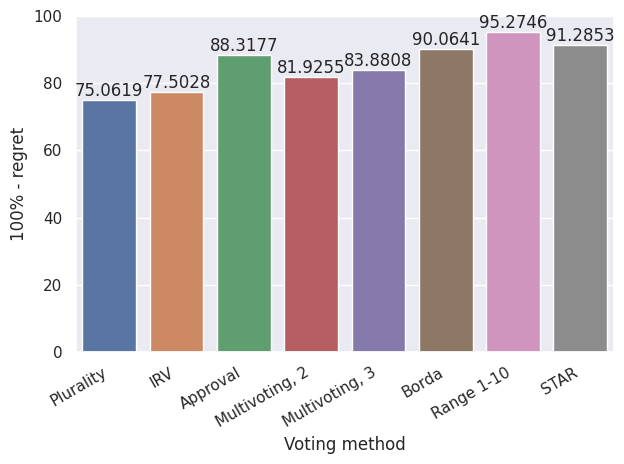

In [41]:
ax = sns.barplot(x=data_x, y=data_y, errorbar=None, hue=data_x, legend=False)
plt.xlabel('Voting method')
plt.ylabel('100% - regret')
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
print(ax.containers)
for i in range(len(data_x)):
    ax.bar_label(ax.containers[i])